In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_data(N):
    data = np.random.randint(0,9, size = (N,10))
    d = data[0]
    X = torch.FloatTensor(data)
    y = torch.FloatTensor([len(d[d==2]) > len(d[d==4]) for d in data])
    return X.long(), y.reshape(-1,1)

In [48]:
class AttentionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = torch.nn.Embedding(10, embedding_dim=5)
        self.query = torch.nn.Parameter(torch.randn(1,12))

        self.make_keys = torch.nn.Linear(5,12)
        self.make_values = torch.nn.Linear(5,1)

        self.final_net = torch.nn.Sequential(
            torch.nn.Linear(1,10),
            torch.nn.ReLU(),
            torch.nn.Linear(10,1),
            torch.nn.Sigmoid()
        )
    
    def attention(self, embedded):
        keys = self.make_keys(embedded)
        query = self.query
        
        qk = torch.einsum('ie,bje->bij', query, keys)
        qknorm = qk/torch.sqrt(torch.FloatTensor([12]))

        att = torch.nn.functional.softmax(qknorm, dim = -1)
        return att

    def values(self, embedded):
        vals = self.make_values(embedded)        
        return vals
    
    def forward(self, X):
        embedded = self.embed(X)
        att = self.attention(embedded)
        vals = self.values(embedded)

        global_response = torch.einsum('bij,bje->bie', att, vals)
        global_response = global_response[:,0,:]
        
        return self.final_net(global_response)
        

In [9]:
def train():
    model = AttentionModel()
    opt = torch.optim.Adam(model.parameters(), lr = 3e-4)
    traj = []
    for i in range(10000):
        X,y = get_data(10)
        pred = model(X)
        loss = torch.nn.functional.binary_cross_entropy(pred,y)
        loss.backward()
        traj.append(float(loss))
        if i % 1000 == 0:
            print(float(loss))
        opt.step()
        opt.zero_grad()
    return model, np.array(traj)
        
tm, traj = train()

0.7685934901237488
0.6128870844841003
0.03646061196923256
0.05500254034996033
0.005053679458796978
0.004941304214298725
0.001919630914926529
0.0011450228048488498
0.0010228360770270228
0.0005009853630326688


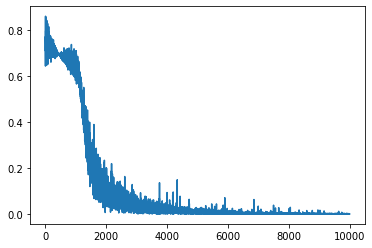

In [10]:
plt.plot(traj)

In [42]:
X = torch.LongTensor([
    [4,2,5,3,8,0,7,3,1,4],
    [3,1,4,1,5,9,2,6,5,3],
    [1,9,2,2,2,2,4,4,3,1],
])

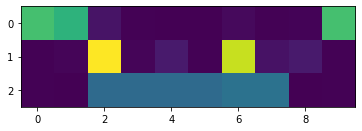

In [43]:
att = tm.attention(tm.embed(X))[:,0,:].detach()
plt.imshow(att)

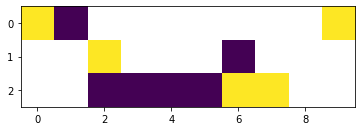

In [46]:
vals = tm.values(tm.embed(X))[:,:,0].detach()
vals = torch.where(att < 0.05, torch.ones_like(vals)*torch.nan, vals)
plt.imshow(vals)

In [47]:
tm(X)

tensor([[2.7955e-07],
        [5.4079e-04],
        [9.9997e-01]], grad_fn=<SigmoidBackward0>)

In [49]:
!open .